<a href="https://colab.research.google.com/github/rohmish2/LLM-Memorization-Paper-Implementation/blob/main/BertBartAnalysiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.9 MB/s eta 0:00:00
--2025-11-03 20:26:13--  https://raw.githubusercontent.com/neulab/BARTScore/main/bart_score.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4221 (4.1K) [text/plain]
Saving to: ‘bart_score.py’

bart_score.py       100%[===================>]   4.12K  --.-KB/s    in 0s      

2025-11-03 20:26:14 (55.9 MB/s) - ‘bart_score.py’ saved [4221/4221]



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]


Prefix Length: 50


Processing entries:   0%|          | 0/997 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Processing entries: 100%|██████████| 997/997 [01:14<00:00, 13.30it/s]


Average BERT Score F1: 0.6539
Average BART Score: -3.4748

Prefix Length: 100


Processing entries: 100%|██████████| 981/981 [01:02<00:00, 15.76it/s]


Average BERT Score F1: 0.6647
Average BART Score: -3.3926

Prefix Length: 200


Processing entries: 100%|██████████| 772/772 [00:43<00:00, 17.79it/s]


Average BERT Score F1: 0.6861
Average BART Score: -3.1957

Prefix Length: 300


Processing entries: 100%|██████████| 300/300 [00:15<00:00, 19.10it/s]


Average BERT Score F1: 0.7028
Average BART Score: -3.0869

Prefix Length: 500


Processing entries: 100%|██████████| 18/18 [00:00<00:00, 20.52it/s]


Average BERT Score F1: 0.7198
Average BART Score: -3.0775

Results saved to bert_bart_results.json


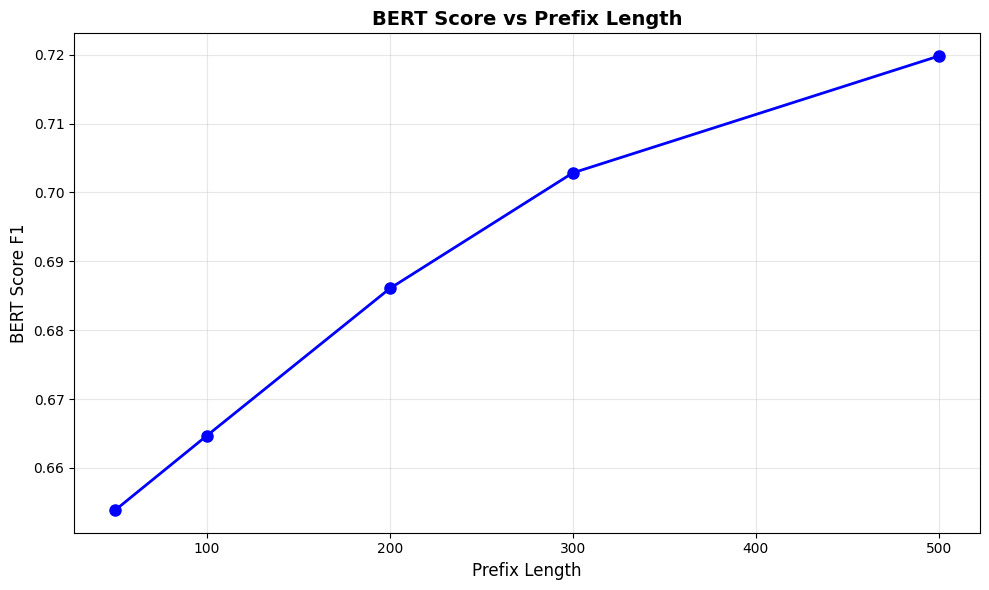

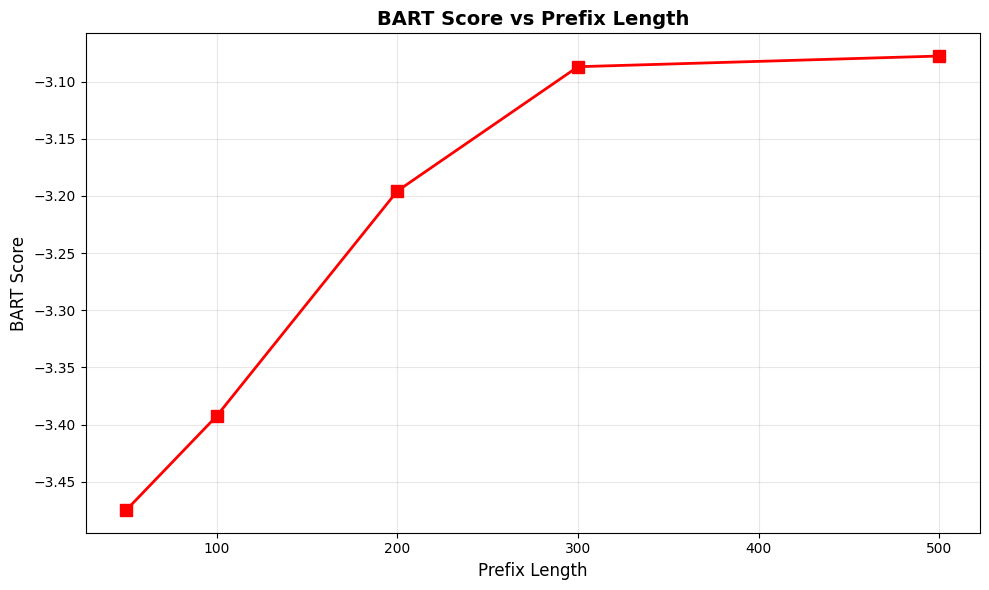

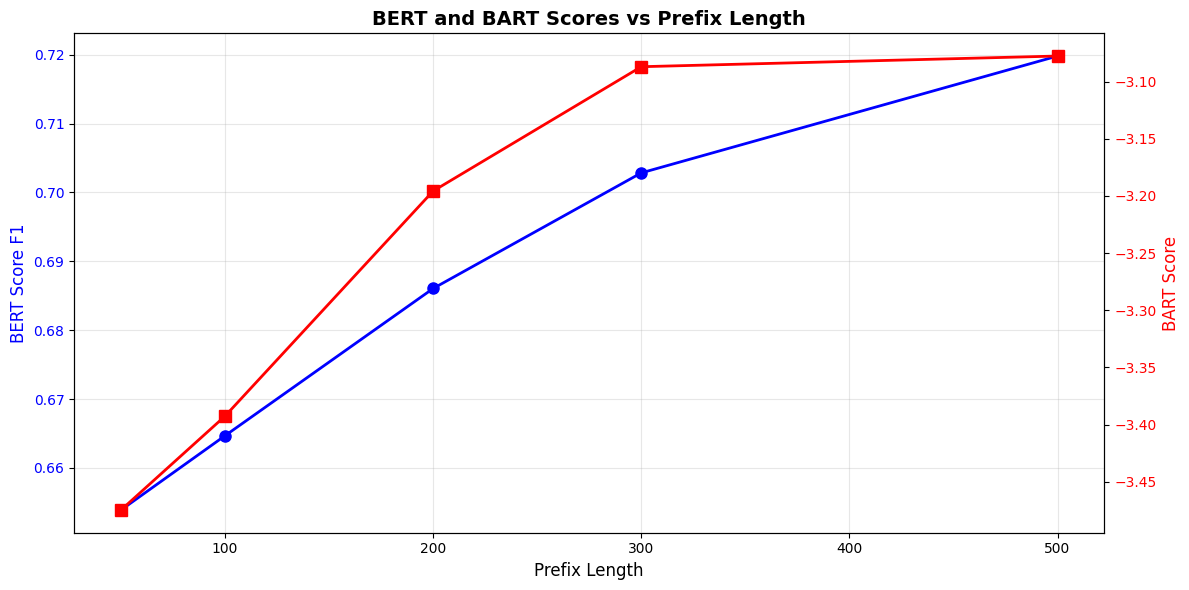


All plots saved successfully!

SUMMARY TABLE
 prefix_length  bert_score  bart_score
            50    0.653890   -3.474826
           100    0.664682   -3.392622
           200    0.686058   -3.195660
           300    0.702841   -3.086876
           500    0.719806   -3.077533


In [ ]:
########################
# author: Rohit Mishra #
########################

!pip install evaluate
!pip install bert-score transformers evaluate
!wget https://raw.githubusercontent.com/neulab/BARTScore/main/bart_score.py

import pandas as pd
import evaluate
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer
from bart_score import BARTScorer

bertscore = evaluate.load("bertscore")
bart_scorer = BARTScorer(device='cuda', checkpoint='facebook/bart-large-cnn')
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
max_length = 512

def evaluate_bert_and_bart(df):
    bert_scores = []
    bart_scores = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing entries"):
        groundtruth = str(row["suffix"])
        response = str(row["generated"])

        groundtruth_tokens = tokenizer(groundtruth, truncation=True, max_length=max_length, return_tensors="pt")
        response_tokens = tokenizer(response, truncation=True, max_length=max_length, return_tensors="pt")
        groundtruth = tokenizer.decode(groundtruth_tokens['input_ids'][0], skip_special_tokens=True)
        response = tokenizer.decode(response_tokens['input_ids'][0], skip_special_tokens=True)

        bert_result = bertscore.compute(
            predictions=[response],
            references=[groundtruth],
            model_type="bert-base-multilingual-cased"
        )
        bert_score_f1 = round(bert_result["f1"][0], 4)
        bert_scores.append(bert_score_f1)

        bart_result = bart_scorer.score(srcs=[response], tgts=[groundtruth], batch_size=1)
        bart_score = round(bart_result[0], 4)
        bart_scores.append(bart_score)

    avg_bert = sum(bert_scores) / len(bert_scores) if bert_scores else 0.0
    avg_bart = sum(bart_scores) / len(bart_scores) if bart_scores else 0.0

    print(f"Average BERT Score F1: {avg_bert:.4f}")
    print(f"Average BART Score: {avg_bart:.4f}")

    return avg_bert, avg_bart

dir = "/content/Results/"
resultsPath = ['results_prefix50.csv', 'results_prefix100.csv',
               'results_prefix200.csv', 'results_prefix300.csv',
               'results_prefix500.csv']
prefixLength = [50, 100, 200, 300, 500]

results = []

for i in range(len(resultsPath)):
    prefixL = prefixLength[i]
    df = pd.read_csv(dir + resultsPath[i])

    print(f"\n{'='*50}")
    print(f"Prefix Length: {prefixL}")
    print(f"{'='*50}")

    avg_bert, avg_bart = evaluate_bert_and_bart(df)

    results.append({
        "prefix_length": prefixL,
        "bert_score": avg_bert,
        "bart_score": avg_bart
    })

with open(dir + 'bert_bart_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("\n" + "="*50)
print("Results saved to bert_bart_results.json")
print("="*50)

prefix_vals = [r["prefix_length"] for r in results]
bert_vals = [r["bert_score"] for r in results]
bart_vals = [r["bart_score"] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(prefix_vals, bert_vals, marker='o', linewidth=2, markersize=8, color='blue')
plt.xlabel('Prefix Length', fontsize=12)
plt.ylabel('BERT Score F1', fontsize=12)
plt.title('BERT Score vs Prefix Length', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(dir + 'bert_score_plot.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(prefix_vals, bart_vals, marker='s', linewidth=2, markersize=8, color='red')
plt.xlabel('Prefix Length', fontsize=12)
plt.ylabel('BART Score', fontsize=12)
plt.title('BART Score vs Prefix Length', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(dir + 'bart_score_plot.png', dpi=300)
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Prefix Length', fontsize=12)
ax1.set_ylabel('BERT Score F1', fontsize=12, color='blue')
ax1.plot(prefix_vals, bert_vals, marker='o', linewidth=2, markersize=8,
         color='blue', label='BERT Score')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('BART Score', fontsize=12, color='red')
ax2.plot(prefix_vals, bart_vals, marker='s', linewidth=2, markersize=8,
         color='red', label='BART Score')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('BERT and BART Scores vs Prefix Length', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.savefig(dir + 'bert_bart_combined_plot.png', dpi=300)
plt.show()

print("\nAll plots saved successfully!")

print("\n" + "="*50)
print("SUMMARY TABLE")
print("="*50)
summary_df = pd.DataFrame(results)
print(summary_df.to_string(index=False))